### Import Libraries

In [1]:
import numpy as np
import pandas as pd
from typing import Tuple, Dict
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score

### Nomor 2


In [2]:
class KMeansMod(object):
    """
    Class to encapsulate the K-Means algorithm
    """

    def __init__(self, n_clusters: int = 3, n_init: int = 10, max_iters: int = 100):
        """
        Initializer function for a class instance

        Inputs:
            n_clusters   -> integer number of clusters to assign
            n_init       -> integer number of times the algorithm will be applied when training
            max_iters    -> maximum number of iterations the algorithm is allowed to run before stopping
        """
        if n_clusters <= 0:
            raise ValueError(f'n_clusters must be a positive integer, got: {n_clusters}')
        if n_init <= 0:
            raise ValueError(f'n_init must be a positive integer, got: {n_init}')
        if max_iters <= 0:
            raise ValueError(f'Input argument max_iters must be a positive integer, got: {max_iters}')
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.centroids = np.array([])
        self.total_wcss = np.inf
        self.wcss_array = np.array([])
        self.max_iters = max_iters

    def __assign_samples(self, X: np.array, centroids: np.array) -> np.array:
        """
        Private function to assign samples to clusters

        Inputs:
            X -> numpy array of input features with shape: [number_samples, number_features]
            centroids -> numpy array of centroids with shape: [n_clusters, number_features]
        Output:
            numpy array indicating cluster assignment per sample with shape: [number_samples,]
        """
        differences = X[:, np.newaxis] - centroids[np.newaxis]
        euclid_dist = np.einsum('ijk,ijk->ij', differences, differences)
        return np.argmin(euclid_dist, axis=1)

    def __update_centroids(self, X: np.array, cluster_assignment: np.array) -> np.array:
        X_clusters = self.__partition_data(X, cluster_assignment)
        return np.array([np.mean(x, axis=0) for x in X_clusters])

    def __partition_data(self, X: np.array, cluster_assignment: np.array) -> list:
        X_assigned = np.concatenate((X, cluster_assignment.reshape(-1, 1)), axis=1)
        X_assigned = X_assigned[X_assigned[:, -1].argsort()]
        return np.split(X_assigned[:, :-1], np.unique(X_assigned[:, -1], return_index=True)[1][1:])

    def __compute_wcss(self, X: np.array, cluster_assignment: np.array, centroids: np.array) -> Tuple[float, np.array]:
        X_clusters = self.__partition_data(X, cluster_assignment)
        wcss_array = np.array([np.einsum('ij,ij', X_clusters[i] - centroids[i, :],
                                         X_clusters[i] - centroids[i, :]) for i in range(self.n_clusters)])
        return (np.sum(wcss_array), wcss_array)

    def fit(self, X: np.array) -> None:
        self.total_wcss = np.inf

        for _ in range(self.n_init):
            # Memastikan sentroid awal mencakup seluruh klaster
            centroids = []
            for i in range(self.n_clusters):
                cluster_points = X[np.random.choice(X.shape[0], 1)]
                while cluster_points.tolist() in centroids:
                    cluster_points = X[np.random.choice(X.shape[0], 1)]
                centroids.append(cluster_points.tolist()[0])

            centroids = np.array(centroids)

            old_centroids = np.copy(centroids)
            centroid_diff = np.ones((self.n_clusters))
            iteration = 0
            while (not np.array_equal(centroid_diff, np.zeros(self.n_clusters))) and iteration < self.max_iters:
                cluster_assignment = self.__assign_samples(X, centroids)
                centroids = self.__update_centroids(X, cluster_assignment)
                centroid_diff = np.abs(old_centroids - centroids)
                iteration += 1
                old_centroids = np.copy(centroids)

            total_wcss, wcss_array = self.__compute_wcss(X, cluster_assignment, centroids)
            if total_wcss < self.total_wcss:
                self.total_wcss = total_wcss
                self.wcss_array = wcss_array
                self.centroids = centroids

    def predict(self, X: np.array) -> np.array:
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return self.__assign_samples(X, self.centroids)

    def return_wcss(self) -> Tuple[float, np.array]:
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return (self.total_wcss, self.wcss_array)

    def return_centroids(self) -> np.array:
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return self.centroids

### Import Data

In [3]:
df = pd.read_excel('/Users/dyovael/Documents/UNAIR/KULIAH/Semester 5/Pembelajaran Mesin (Praktikum)/AirQualityUCI.xlsx')
selected_columns = df[['NMHC(GT)', 'RH']]
data = (selected_columns)
print (data)

      NMHC(GT)         RH
0          150  48.875001
1          112  47.700000
2           88  53.975000
3           80  60.000000
4           51  59.575001
...        ...        ...
9352      -200  29.250000
9353      -200  23.725000
9354      -200  18.350000
9355      -200  13.550000
9356      -200  13.125000

[9357 rows x 2 columns]


In [4]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [5]:
# Buat model KMeans
clt = KMeansMod(n_clusters = 5, max_iters = 300)

In [6]:
# Cocokkan model dengan data
clt.fit(data_scaled)

In [7]:
clusters_predict = clt.predict(data_scaled)

In [8]:
centers_pred = clt.return_centroids()

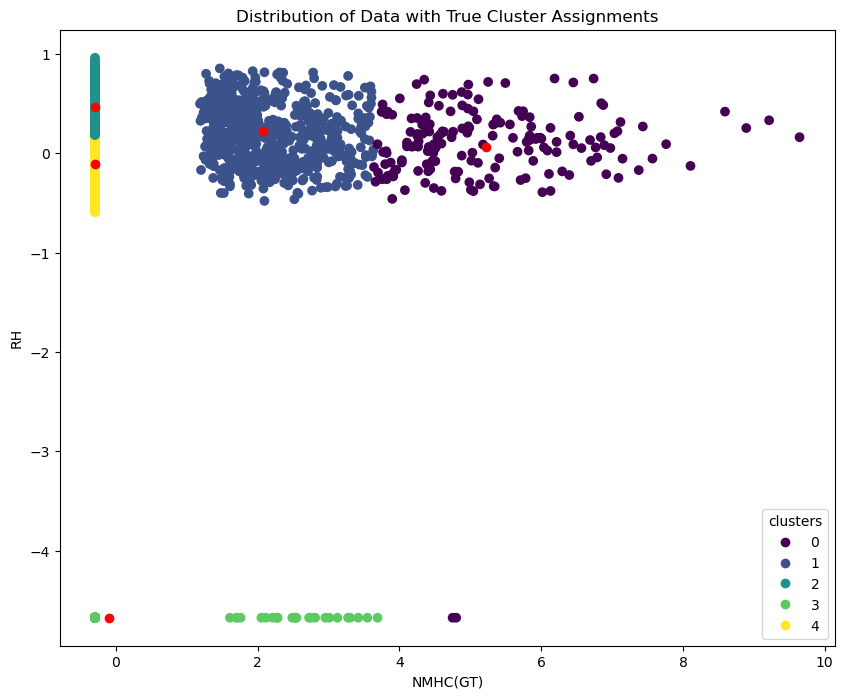

In [9]:
# visualise data
fig, ax = plt.subplots(figsize=(10,8))
sc = ax.scatter(data_scaled[:,0],data_scaled[:,1],c=clusters_predict)
sc_centers = ax.scatter(centers_pred[:,0],centers_pred[:,1],c='r')
plt.xlabel('NMHC(GT)')
plt.ylabel('RH')
plt.title('Distribution of Data with True Cluster Assignments')
ax.legend(*sc.legend_elements(), title='clusters')
plt.show()

In [10]:
# compute WCSS for the resulting clusters
total_wcss, wcss_array = clt.return_wcss()
print(total_wcss)

1152.9621297183785


### Nomor 3

/Users/dyovael/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


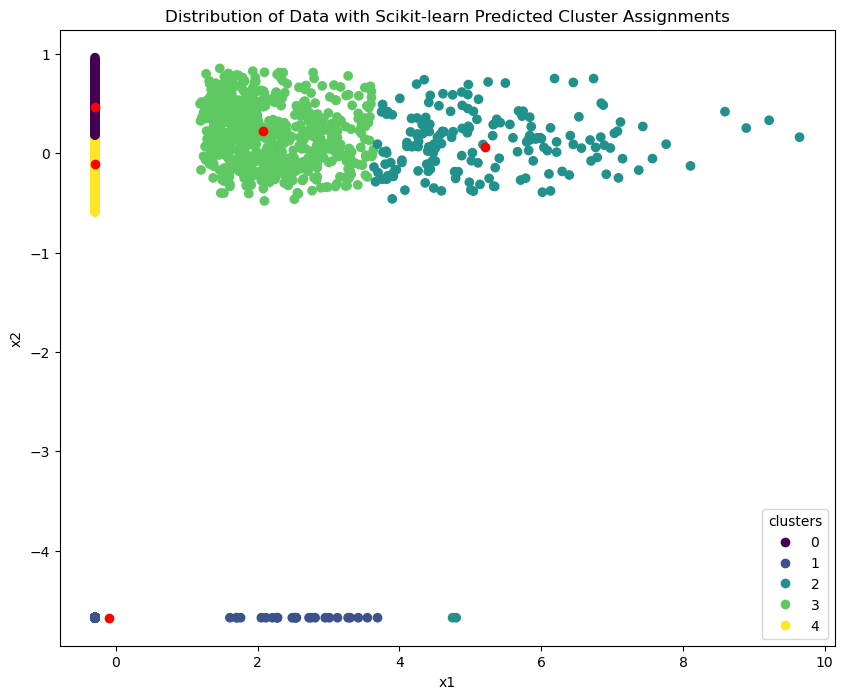

In [11]:
# Buat model KMeans
clt = KMeans(n_clusters=5, max_iter=300, random_state=0)

# Cocokkan model dengan data
clt.fit(data_scaled)

# Dapatkan prediksi
y_pred = clt.predict(data_scaled)

# Dapatkan prediksi sentroid
centers_pred = clt.cluster_centers_

# Visualisasikan prediksi
fig, ax = plt.subplots(figsize=(10,8))
sc = ax.scatter(data_scaled[:,0],data_scaled[:,1],c=y_pred)
sc_centers = ax.scatter(centers_pred[:,0],centers_pred[:,1],c='r')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Distribution of Data with Scikit-learn Predicted Cluster Assignments')
ax.legend(*sc.legend_elements(), title='clusters')
plt.show()

In [12]:
## compute WCSS for the resulting clusters
total_wcss2 = clt.inertia_
print(total_wcss2)

1152.979590581316


In [4]:
pip install numpy scipy scikit-learn


     ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
     ---------------------------------------- 0.1/9.2 MB 1.7 MB/s eta 0:00:06
      --------------------------------------- 0.1/9.2 MB 2.4 MB/s eta 0:00:04
     - -------------------------------------- 0.3/9.2 MB 2.6 MB/s eta 0:00:04
     - -------------------------------------- 0.4/9.2 MB 2.3 MB/s eta 0:00:04
     -- ------------------------------------- 0.5/9.2 MB 2.3 MB/s eta 0:00:04
     -- ------------------------------------- 0.6/9.2 MB 2.3 MB/s eta 0:00:04
     --- ------------------------------------ 0.8/9.2 MB 2.5 MB/s eta 0:00:04
     ---- ----------------------------------- 0.9/9.2 MB 2.6 MB/s eta 0:00:04
     ---- ----------------------------------- 1.1/9.2 MB 2.7 MB/s eta 0:00:03
     ----- ---------------------------------- 1.2/9.2 MB 2.8 MB/s eta 0:00:03
     ------ --------------------------------- 1.4/9.2 MB 2.9 MB/s eta 0:00:03
     ------ --------------------------------- 1.6/9.2 MB 2.9 MB/s eta 

c:\Users\randy\anaconda3\envs\ai\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\randy\anaconda3\envs\ai\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\randy\anaconda3\envs\ai\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\randy\anaconda3\envs\ai\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

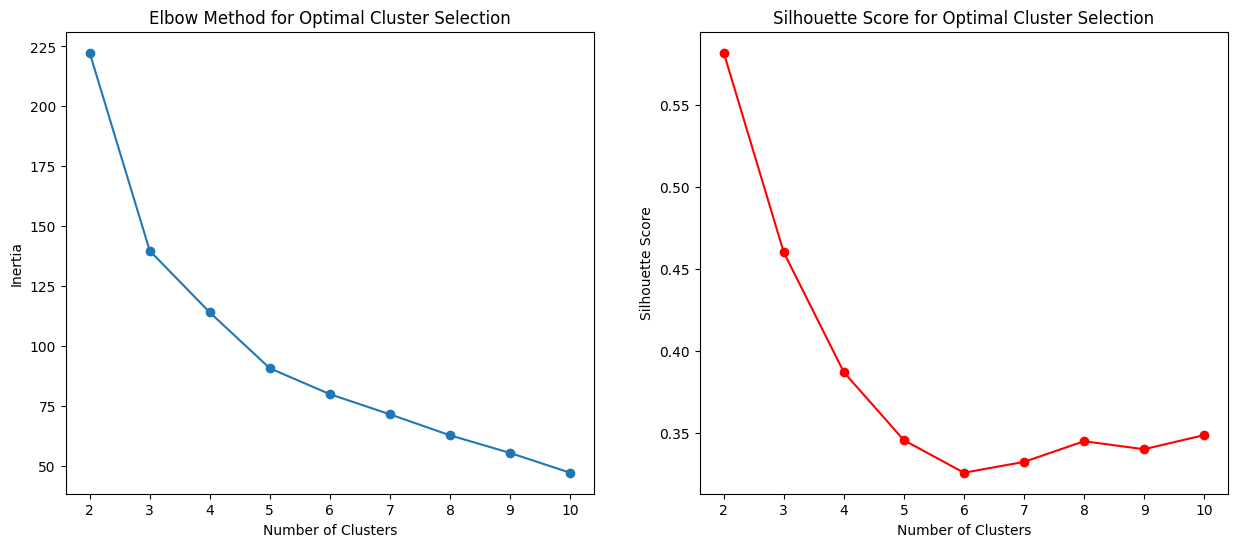

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

# Load dataset iris sebagai contoh
data = load_iris()
X = data.data

# Lakukan penskalaan data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)

# Buat list untuk menyimpan nilai inersia dan silhouette score
inertia_values = []
silhouette_scores = []

# Coba jumlah cluster dari 2 hingga 10 (silhouette score tidak bisa dihitung untuk 1 cluster)
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, max_iter=300, random_state=0)
    kmeans.fit(data_scaled)
    inertia_values.append(kmeans.inertia_)

    # Hitung silhouette score
    score = silhouette_score(data_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Plot grafik untuk Inertia
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia_values, marker='o')
plt.title('Elbow Method for Optimal Cluster Selection')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Plot grafik untuk Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o', color='red')
plt.title('Silhouette Score for Optimal Cluster Selection')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.show()
